# Introduzione 

In questa lezione vogliamo studiare computazionalmente le proprietà termodinamiche del modello di Ising 1D attraverso due diversi algoritmi: l'algoritmo di Gibbs e l'algortimo Metropolis. 

* L'**algortimo di Metropolis** è quello che abbiamo già studiato nelle lezioni precedenti. In quest caso specifico, la probabilità condizionata $T(x|y)$ è una distribuzione uniforme su tutto lo spazio, ossia scegliamo ad ogni iterazione uno spin generico. Invece la distribuzione di accettazione $A(x|y)$ è data dal rapporto fra i pesi di Boltzmann delle due configurazioni: 
$$A(x|y)=\min \left[ 1, e^{-\beta(E_{ x} -E_{y})}\right]$$

* L'**algortimo di Gibbs** si fonda anch'esso sull'idea di costruire una catena di Markov nello spazio delle configurazioni dove però utilizziamo come probabilità di transizione $T(\vec x| \vec y)$ la seguente probabilità condizionata:
$$T (\vec x| \vec y ) = p_{ 1| n −1} ( x_k { y_i : i \neq k } ) \cdot \prod_{i(\neq k)} \delta  ( x_i - y_ i ) $$
Questa scelta consiste nello stimare il valore dello spin $k$-esimo a partire dal valore di tutti gli altri spin del sistema, proprio come se agissero da bagno termino. Infatti questo algoritmo viene anche chiamato "Algoritmo di Heat-Bath". Osseviamo infine che questa scelta specifica per $T$ comporta che la probabilità di accettazione $A(\vec x| \vec y)=1 \quad \forall \vec x$.

Praticamente procediamo prima a ricavare il tempo di equilibrazione e poi ci concentriamo sul ricavare le quantità di nostro interesse.

**ATTENZIONE:** Tutte le quantità saranno espresse come valore per unità di spin

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
from scipy.optimize import curve_fit
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import subprocess as sb
from os import system
import os

sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.7, color_codes=True, rc=None)

In [2]:
path=  r'/home/elia/Scrivania/SimulazioneNumerica/Exercises_06/Exercises_06.1/'
os.chdir(path)

# Tempo di equilibrazione 

Quello che ora vogliamo fare è studiare quale sia il tempo di equilibrazione. Per farlo consideriamo il worst-case scenario, ossia partiamo da una configurazione a $T=\infty$ e chiediamo che il sistema si porti alla temperatura $T=4$. Si tratta del caso limite in quanto il $\Delta T$ per le altre simulazioni è costante ed ogni volta ripartiamo dalla configurazione precedente. In particolare scegliamo i seguenti parametri per la simulazione:

|Parametri |Valori assegnati|
|-----|--------|
|T    |4     |
|J  |1      |
|h    |0     |


In [7]:
# 0. temp; 1.nspin; 2. J; 3. h; 4. metro; 5. nblk; 6. nstep; 7. oldconfig; 8. equilibration_time;

for element in range(2):
    if(element == 0):
        print("GIBBS")
    elif(element == 1):
        print("METROPOLIS")

    lines = ['4','50','1.0','0',str(element),'2000','1','1']
    with open('input.dat', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')
        
    sb.call('./clean.sh', shell=True)
    os.system('./Monte_Carlo_ISING_1D.exe %f %f')

    if(element == 0): 
        ene = np.loadtxt(path+"output.ene.0", unpack = True)
        heat = np.loadtxt(path+"output.heat.0", unpack = True)
        mag = np.loadtxt(path+"output.mag.0", unpack = True)
        chi = np.loadtxt(path+"output.chi.0", unpack = True)


        df_gibbs = pd.DataFrame({'ene': ene[2,:],'ene_std': ene[3,:], 'ene_ist': ene[1,:],
                          'heat': heat[2,:], 'heat_std':heat[3,:], 'heat_ist': heat[1,:],
                           'mag': mag[2,:], 'mag_std': mag[3,:], 'mag_ist': mag[1,:],
                           'chi': chi[2,:], 'chi_std': chi[3,:], 'chi_ist': chi[1,:],      
                          })
    if(element == 1): 
        ene = np.loadtxt(path+"output.ene.0", unpack = True)
        heat = np.loadtxt(path+"output.heat.0", unpack = True)
        mag = np.loadtxt(path+"output.mag.0", unpack = True)
        chi = np.loadtxt(path+"output.chi.0", unpack = True)


        df_met = pd.DataFrame({'ene': ene[2,:],'ene_std': ene[3,:], 'ene_ist': ene[1,:],
                          'heat': heat[2,:], 'heat_std':heat[3,:], 'heat_ist': heat[1,:],
                           'mag': mag[2,:], 'mag_std': mag[3,:], 'mag_ist': mag[1,:],
                           'chi': chi[2,:], 'chi_std': chi[3,:], 'chi_ist': chi[1,:],      
                          })

GIBBS
METROPOLIS


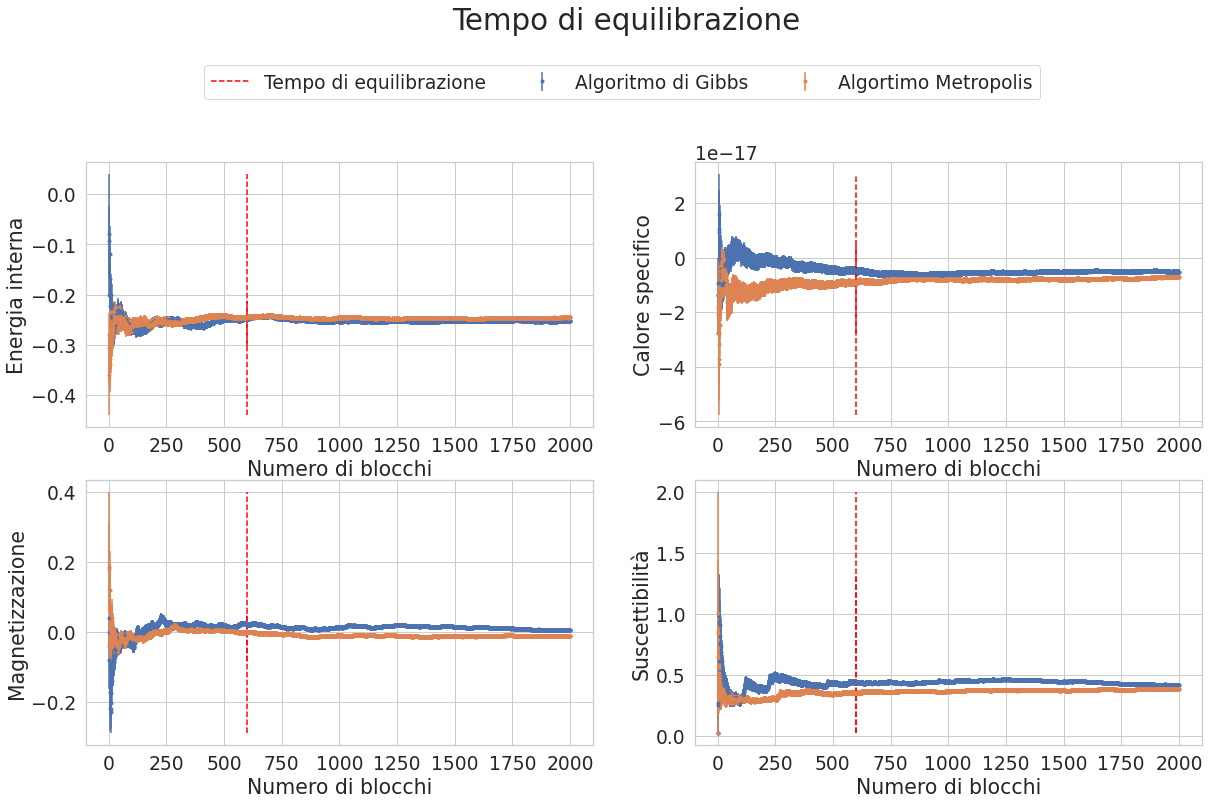

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20,12)); 
fig.suptitle('Tempo di equilibrazione', fontsize='x-large')
fig.subplots_adjust(top=0.8)
ax = ax.ravel()


quantity = ['ene', 'heat', 'mag', 'chi']
label= ['Energia interna' , 'Calore specifico', 'Magnetizzazione','Suscettibilità']

for i in range(4):        
    ax[i].errorbar(
        np.arange(1,np.size(ene[0,:])+1,1),
        df_gibbs[quantity[i]],
        yerr = df_gibbs[quantity[i]+'_std'], 
        marker='.', linestyle="", label='Algoritmo di Gibbs'
    );
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('Numero di blocchi')
    ax[i].vlines(600,min(df_gibbs[quantity[i]]-df_gibbs[quantity[i]+'_std']), max(df_gibbs[quantity[i]]+df_gibbs[quantity[i]+'_std']), linestyle='--', color='red', label='Tempo di equilibrazione')

for i in range(4):        
    ax[i].errorbar(
        np.arange(1,np.size(ene[0,:])+1,1),
        df_met[quantity[i]],
        yerr = df_met[quantity[i]+'_std'], 
        marker='.', linestyle="", label='Algortimo Metropolis'
    );
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('Numero di blocchi')
    ax[i].vlines(600,min(df_met[quantity[i]]-df_met[quantity[i]+'_std']), max(df_met[quantity[i]]+df_met[quantity[i]+'_std']), linestyle='--', color='red')

    

ax[1].legend(bbox_to_anchor=(0.7,1.4), ncol=3);

Da questa analisi osserviamo che dopo 600 blocchi, tutte le quantità sembrano essere stabili per entrambi gli algoritmi. Scegliamo quindi questo valore come tempo di equilibrazione.

# Misure con $h=0$

Studiamo ora come variano le principali proprietà del sistema di spin al variare delle termperatura confrontando poi i valori ottenuti con le predizioni teoriche. In particolare utilizziamo i seguenti parametri:


|Parametri |Valori assegnati|
|-----|--------|
|T    |0.2 - 4.0|
|J  |1      |
|h    |0     |
|n° spin  |50      |
|n° block|200     |
|n° step  |1000      |

Abbiamo scelto di lavorare con 1000 passi per blocco. Abbiamo infatti visto nella lezione precedente che i diversi passi sono correlati con lunghezze caratteristiche di circa 50 passi. Quindi scegliendo la lunghezza dei blocchi pari a 1000, siamo ragionevolmente certi di star considerando blocchi indipendenti.

In [10]:
points=50
start =0.
T = np.linspace(4.0,0.2,num=points)

In [11]:
ene_gibs = np.zeros(len(T))
heat_gibs = np.zeros(len(T))
mag_gibs = np.zeros(len(T))
chi_gibs = np.zeros(len(T))

ene_gibs_std = np.zeros(len(T))
heat_gibs_std = np.zeros(len(T))
mag_gibs_std = np.zeros(len(T))
chi_gibs_std = np.zeros(len(T))

ene_met = np.zeros(len(T))
heat_met = np.zeros(len(T))
mag_met = np.zeros(len(T))
chi_met = np.zeros(len(T))

ene_met_std = np.zeros(len(T))
heat_met_std = np.zeros(len(T))
mag_met_std = np.zeros(len(T))
chi_met_std = np.zeros(len(T))

In [12]:
for element in range(2):
    if(element == 0):
        print("GIBBS")
    elif(element == 1):
        print("\n METROPOLIS")
    j=0
    for i in T:
        print('--- Actual temperature', i, end='\r')
        temp = i
        if i==T[0]:
            lines = [str(i),'50','1.0','0',str(element),'200','1000','0']
        else: 
            lines = [str(i),'50','1.0','0',str(element),'200','1000','1']
        with open('input.dat', 'w') as f:
            for line in lines:
                f.write(line)
                f.write('\n')
        sb.call('./clean.sh', shell=True)
        os.system('./Monte_Carlo_ISING_1D.exe %f %f')
        
        ene = np.loadtxt(path+"output.ene.0", unpack = True)
        heat = np.loadtxt(path+"output.heat.0", unpack = True)
        mag = np.loadtxt(path+"output.mag.0", unpack = True)
        chi = np.loadtxt(path+"output.chi.0", unpack = True)

        if(element == 0): 
            ene_gibs[j]=ene[2,len(ene)-1] 
            heat_gibs[j]=heat[2,len(heat)-1] 
            mag_gibs[j]=mag[2,len(mag)-1] 
            chi_gibs[j]=chi[2,len(chi)-1] 
            
            ene_gibs_std[j]=ene[3,len(ene)-1] 
            heat_gibs_std[j]=heat[3,len(heat)-1] 
            mag_gibs_std[j]=mag[3,len(mag)-1] 
            chi_gibs_std[j]=chi[3,len(chi)-1] 
            
        if(element == 1): 
            ene_met[j]=ene[2,len(ene)-1] 
            heat_met[j]=heat[2,len(heat)-1] 
            mag_met[j]=mag[2,len(mag)-1] 
            chi_met[j]=chi[2,len(chi)-1] 
            
            ene_met_std[j]=ene[3,len(ene)-1] 
            heat_met_std[j]=heat[3,len(heat)-1] 
            mag_met_std[j]=mag[3,len(mag)-1] 
            chi_met_std[j]=chi[3,len(chi)-1] 
            
        j+=1

GIBBS
--- Actual temperature 0.27755102040816304
 METROPOLIS


In [13]:
df_gibs = pd.DataFrame({'ene': ene_gibs,'ene_std': ene_gibs_std,
                  'heat': heat_gibs, 'heat_std':heat_gibs_std,
                   'mag': mag_gibs, 'mag_std': mag_gibs_std,
                   'chi': chi_gibs, 'chi_std': chi_gibs_std      
                  })
df_met = pd.DataFrame({'ene': ene_met,'ene_std': ene_met_std,
                  'heat': heat_met, 'heat_std':heat_met_std,
                   'mag': mag_met, 'mag_std': mag_met_std,
                   'chi': chi_met, 'chi_std': chi_met_std      
                  })

In [14]:
# ENERGIA
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

# CAPACITA' TERMICA
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

# MAGNETIZZAZIONE
h=0.0 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

# SUSCETTIBILITA'
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)


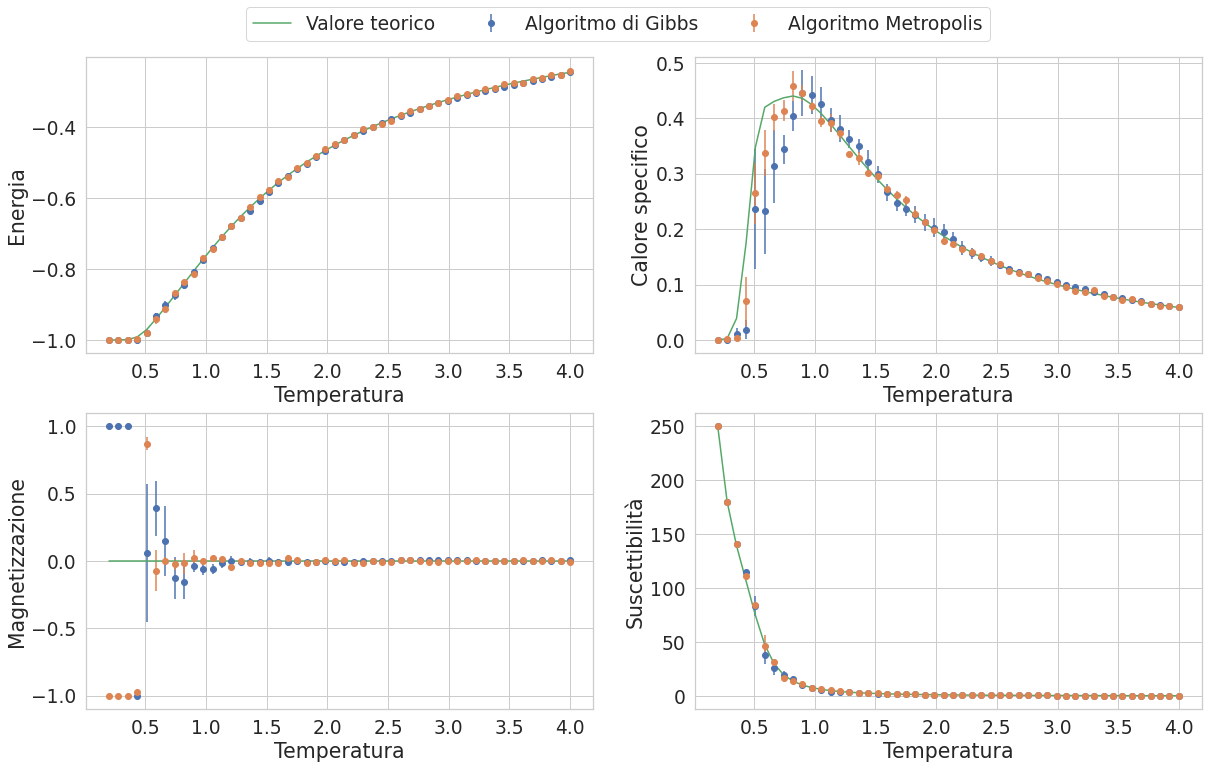

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20,12)); 
fig.suptitle(r'Ising 1D: $h=0$', fontsize='x-large')
ax = ax.ravel()


quantity =['ene', 'heat', 'mag', 'chi']
label= ['Energia interna', 'Calore specifico', 'Magnetizzazione','Suscettibilità']

for i in range(4):        
    ax[i].errorbar(
        T,
        df_gibs[quantity[i]],
        yerr = df_gibs[quantity[i]+'_std'], 
        marker='o', linestyle="", label='Algoritmo di Gibbs'
    );
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('Temperatura')
    
for i in range(4):        
    ax[i].errorbar(
        T,
        df_met[quantity[i]],
        yerr = df_met[quantity[i]+'_std'], 
        marker='o', linestyle="", label='Algoritmo Metropolis'
    );
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('Temperatura')

ax[0].plot(T, e)
ax[1].plot(T, heat, label='Valore teorico')
ax[2].plot(T, M)
ax[3].plot(T, X)

ax[1].legend(bbox_to_anchor=(0.6,1.2), ncol=3);

I risultati ottenuti sono perfettamente compatibili con la previsione teorica. L'unica caso in cui si ha una discrepanza fra valore atteso e misura è nella magnetizzazione per basse temperature, ossia $T\leq 1$. Tuttavia essa è dovuta al fatto che, in assenza di campo esterno $h=0$ il sistema rompe spontaneamente la simmetria e si porta con probabilità $p=0.5$ in uno stato con tutti spin up, quindi $m=1$, o in uno stato con tutti spin down, quindi $m=-1$.

Studiamo ora il caso in cui $h\neq 0 $ così da verificare che questo effetto non sia più presente.

# Misure con $h= 0.02$

Studiamo ora come variano le principali proprietà del sistema di spin al variare delle termperatura confrontando poi i valori ottenuti con le predizioni teoriche. In particolare utilizziamo i seguenti parametri:


|Parametri |Valori assegnati|
|-----|--------|
|T    |0.2 - 4.0|
|J  |1      |
|h    |0.02     |
|n° spin  |50      |
|n° block|200     |
|n° step  |1000      |

In [16]:
for element in range(2):
    if(element == 0):
        print("GIBBS")
    elif(element == 1):
        print("\n METROPOLIS")
    j=0
    for i in T:
        print('--- Actual temperature', i, end='\r')
        temp = i
        if i==T[0]:
            lines = [str(i),'50','1.0','0.02',str(element),'200','1000','0']
        else: 
            lines = [str(i),'50','1.0','0.02',str(element),'200','1000','1']
        with open('input.dat', 'w') as f:
            for line in lines:
                f.write(line)
                f.write('\n')
        sb.call('./clean.sh', shell=True)
        os.system('./Monte_Carlo_ISING_1D.exe %f %f')
        
        ene = np.loadtxt(path+"output.ene.0", unpack = True)
        heat = np.loadtxt(path+"output.heat.0", unpack = True)
        mag = np.loadtxt(path+"output.mag.0", unpack = True)
        chi = np.loadtxt(path+"output.chi.0", unpack = True)

        if(element == 0): 
            ene_gibs[j]=ene[2,len(ene)-1] 
            heat_gibs[j]=heat[2,len(heat)-1] 
            mag_gibs[j]=mag[2,len(mag)-1] 
            chi_gibs[j]=chi[2,len(chi)-1] 
            
            ene_gibs_std[j]=ene[3,len(ene)-1] 
            heat_gibs_std[j]=heat[3,len(heat)-1] 
            mag_gibs_std[j]=mag[3,len(mag)-1] 
            chi_gibs_std[j]=chi[3,len(chi)-1] 
            
        if(element == 1): 
            ene_met[j]=ene[2,len(ene)-1] 
            heat_met[j]=heat[2,len(heat)-1] 
            mag_met[j]=mag[2,len(mag)-1] 
            chi_met[j]=chi[2,len(chi)-1] 
            
            ene_met_std[j]=ene[3,len(ene)-1] 
            heat_met_std[j]=heat[3,len(heat)-1] 
            mag_met_std[j]=mag[3,len(mag)-1] 
            chi_met_std[j]=chi[3,len(chi)-1] 
            
        j+=1

GIBBS
--- Actual temperature 0.27755102040816304
 METROPOLIS


In [17]:
df_gibs = pd.DataFrame({'ene': ene_gibs,'ene_std': ene_gibs_std,
                  'heat': heat_gibs, 'heat_std':heat_gibs_std,
                   'mag': mag_gibs, 'mag_std': mag_gibs_std,
                   'chi': chi_gibs, 'chi_std': chi_gibs_std      
                  })
df_met = pd.DataFrame({'ene': ene_met,'ene_std': ene_met_std,
                  'heat': heat_met, 'heat_std':heat_met_std,
                   'mag': mag_met, 'mag_std': mag_met_std,
                   'chi': chi_met, 'chi_std': chi_met_std      
                  })

In [18]:
# ENERGIA
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

# CAPACITA' TERMICA
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

# MAGNETIZZAZIONE
h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

# SUSCETTIBILITA'
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)


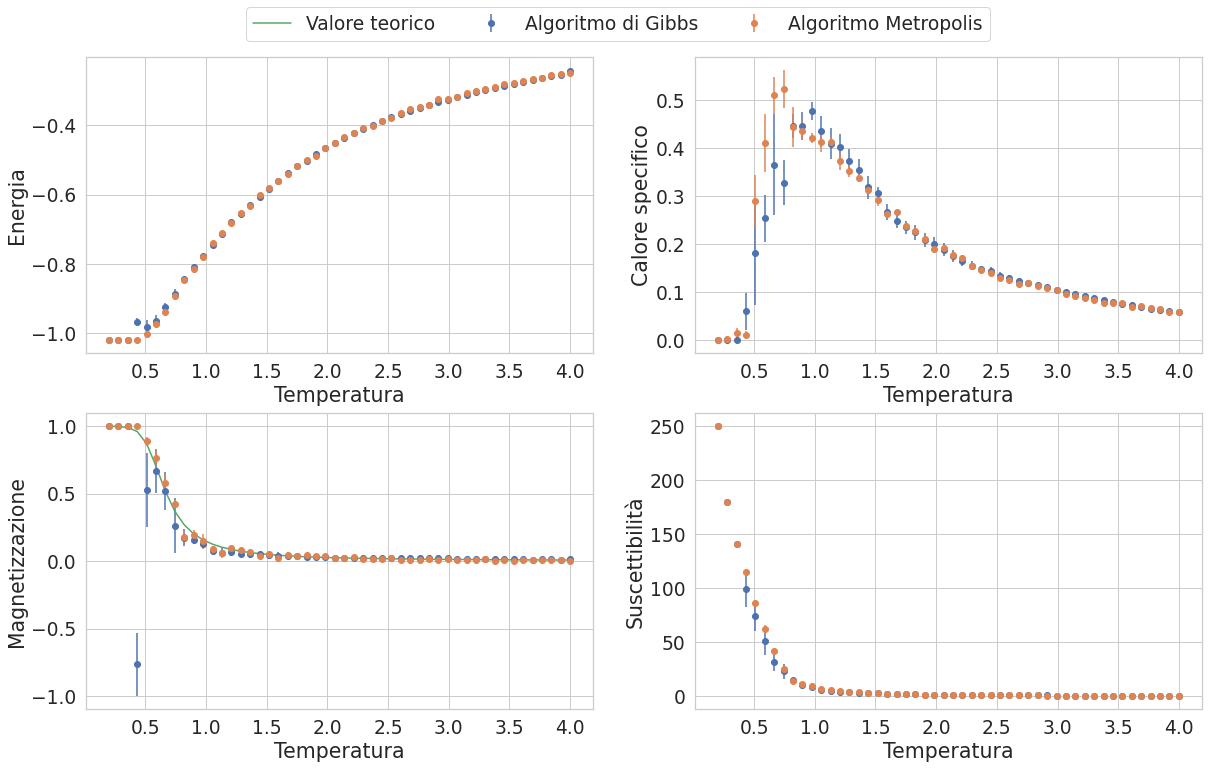

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(20,12)); 
fig.suptitle(r'Ising 1D: $h=0.02$', fontsize='x-large')
ax = ax.ravel()


quantity =['ene', 'heat', 'mag', 'chi']
label= ['Energia interna', 'Calore specifico', 'Magnetizzazione','Suscettibilità']

for i in range(4):        
    ax[i].errorbar(
        T,
        df_gibs[quantity[i]],
        yerr = df_gibs[quantity[i]+'_std'], 
        marker='o', linestyle="", label='Algoritmo di Gibbs'
    );
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('Temperatura')
    
for i in range(4):        
    ax[i].errorbar(
        T,
        df_met[quantity[i]],
        yerr = df_met[quantity[i]+'_std'], 
        marker='o', linestyle="", label='Algoritmo Metropolis'
    );
    ax[i].set_ylabel(label[i])
    ax[i].set_xlabel('Temperatura')

ax[2].plot(T, M,  label='Valore teorico')

ax[2].legend(bbox_to_anchor=(1.8,2.4), ncol=3);

Vediamo che effettivamente in questo caso la magnetizzazione tende a 1 quando $T\rightarrow 0$. Questo ci dice che il campo esterno determina la direzione preferenziale di ordinamento degli spin rompendo la simmetria del problema.